In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm

In [2]:
sns.set_theme()
beta_true = 0.15
alpha = 0.1
gamma = 0.05
prior_mu = -3
prior_sigma = 1
n_zones = 1
N = 100
T = 52
K = 30

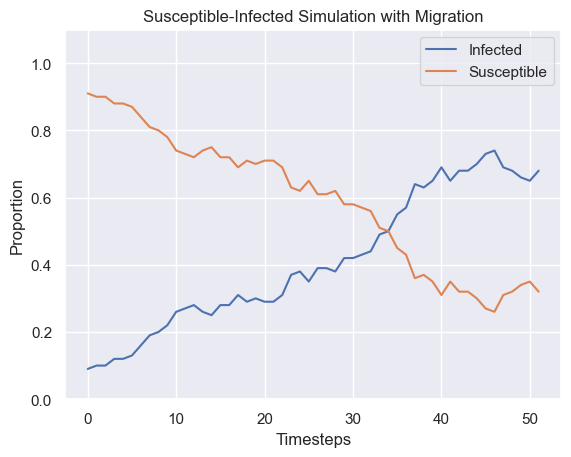

In [3]:
si_model = SIModel(alpha, gamma, beta_true, 
                    n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)

x_o_raw = si_model.get_observed_data(29)
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Infected")
plt.plot(S_o, label="Susceptible")
plt.legend(loc="upper right")
plt.xlabel("Timesteps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation with Migration")
plt.show()

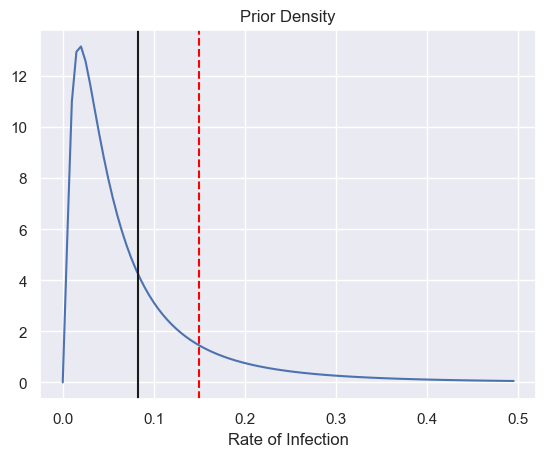

In [4]:
# visualize prior
np.random.seed(10)
x = np.arange(0, 0.5, 0.005)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma))
ax.set_xlabel("Rate of Infection")
ax.set_title(f"Prior Density")
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
plt.axvline(prior_mean, color="k")
plt.axvline(beta_true, color="red", linestyle="--")
plt.show()

In [5]:
# np.random.seed(10)
# x = np.arange(-6, 0, 0.01)
# ax = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma))
# ax.set_xlabel("Rate of Infection")
# ax.set_title(f"Prior Density (Log Scale)")
# plt.axvline(prior_mu, color="k")
# plt.axvline(np.log(beta_true), color="red", linestyle="--")
# plt.show()

A reasonably well-calibrated prior: $P(\beta > \beta^*) = 0.15$.

### Prior Predictive Check

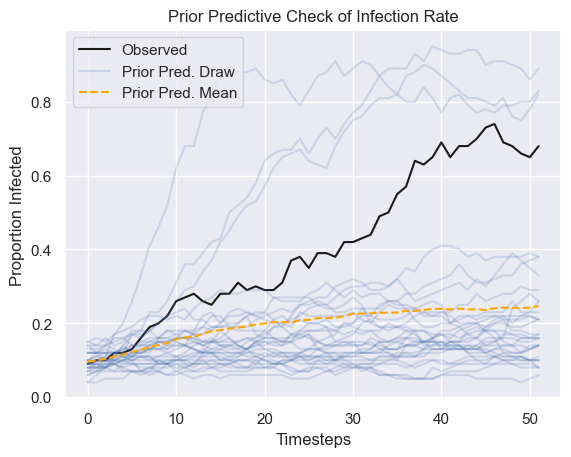

In [32]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=K, random_state=2))
prior_predictive = np.empty((K, T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i], 
                    n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    prior_predictive[i] =  np.array(x_rep)[0]
prp_mean = prior_predictive.mean(0)

labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Prior Predictive Check of Infection Rate")
plt.ylabel("Proportion Infected")
plt.xlabel("Timesteps")
plt.show()

## ABC

In [35]:
abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
abc_samples = []

args = list(zip([True] * 5, [0.05, 0.01, 0.005, 0.001, 0.0005])) + \
        list(zip([False] * 4, [0.1, 0.05, 0.01, 0.005]))
for summarize, eps in args:
    si_model = SIModel(alpha, gamma, beta_true, 
                    n_zones, prior_mu, prior_sigma, 
                   N, T, summarize=summarize)
    prior_sampler = lambda: si_model.sample_logbeta(1)
    simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
    x_o = si_model.get_observed_data(29)
    if not summarize:
        x_o = x_o.transpose(0, 1)
    S = 100
    print(f"epsilon: {eps}")
    posterior_sample, errors = abc_rejection_sampler(
        S, eps, prior_sampler, simulator, x_o, max_attempts=30000,
        summarize=summarize
        )
    print("***")
    abc_data["summarize"].append(summarize)
    abc_data["epsilon"].append(eps)
    abc_data["simulations"].append((errors > 0).sum())
    abc_samples.append(posterior_sample[:,0])

epsilon: 0.05
Time lapsed: 0.21 seconds
With tolerance 0.05, acceptance rate: 0.476190
Total number of attempts: 210
***
epsilon: 0.01
Time lapsed: 0.53 seconds
With tolerance 0.01, acceptance rate: 0.157480
Total number of attempts: 635
***
epsilon: 0.005
Time lapsed: 0.84 seconds
With tolerance 0.005, acceptance rate: 0.099305
Total number of attempts: 1,007
***
epsilon: 0.001
Time lapsed: 1.82 seconds
With tolerance 0.001, acceptance rate: 0.045413
Total number of attempts: 2,202
***
epsilon: 0.0005
Time lapsed: 2.44 seconds
With tolerance 0.0005, acceptance rate: 0.033944
Total number of attempts: 2,946
***
epsilon: 0.1
Time lapsed: 0.12 seconds
With tolerance 0.1, acceptance rate: 0.680272
Total number of attempts: 147
***
epsilon: 0.05
Time lapsed: 0.22 seconds
With tolerance 0.05, acceptance rate: 0.381679
Total number of attempts: 262
***
epsilon: 0.01
Time lapsed: 1.35 seconds
With tolerance 0.01, acceptance rate: 0.060569
Total number of attempts: 1,651
***
epsilon: 0.005
Tim

In [43]:
df_abc = pd.DataFrame(abc_data)

In [44]:
abc_posterior = np.array(abc_samples)
df_abc["Posterior Mean"] = np.exp(abc_posterior.mean(1))

In [85]:
df_abc[".05"] = np.exp(np.quantile(abc_posterior, 0.05, 1))
df_abc[".95"] = np.exp(np.quantile(abc_posterior, 0.95, 1))

In [59]:
np.exp(np.quantile(abc_posterior, 0.95, 1))

array([0.1847306 , 0.17541101, 0.16670984, 0.1645504 , 0.16419534,
       0.22544493, 0.19638495, 0.16217723, 0.16614462])

In [61]:
np.exp(norm(-1.939, 0.161).ppf(.05))

0.11038053943186552

In [62]:
np.exp(norm(-1.939, 0.161).ppf(.95))

0.18746210398842256

In [75]:
df_abc

,summarize,epsilon,simulations,Posterior Mean
0,True,0.0500,210,0.093597
1,True,0.0100,635,0.119480
2,True,0.0050,1007,0.121581
3,True,0.0010,2202,0.124746
4,True,0.0005,2945,0.123559
5,False,0.1000,147,0.082351
6,False,0.0500,262,0.108918
7,False,0.0100,1651,0.127251
8,False,0.0050,6014,0.134714


ValueError: 0     True
1     True
2     True
3     True
4     True
5    False
6    False
7    False
8    False
Name: summarize, dtype: bool is not a valid value for color

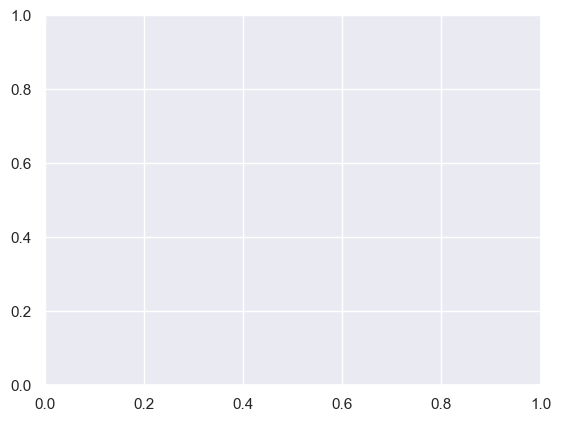

In [92]:
ax = plt.plot(df_abc["simulations"], df_abc["Posterior Mean"], color=df_abc["summarize"])
ax.axhline(y = 0.15, color="k", linestyle=":")
ax.plot(256, np.exp(-1.939), "ro")
plt.show()

In [114]:
df_abc[:5]

,summarize,epsilon,simulations,Posterior Mean,.05,.95,log-sim
0,True,0.0500,210,0.093597,0.041435,0.184731,5.347108
1,True,0.0100,635,0.119480,0.082237,0.175411,6.453625
2,True,0.0050,1007,0.121581,0.085388,0.166710,6.914731
3,True,0.0010,2202,0.124746,0.094964,0.164550,7.697121
4,True,0.0005,2945,0.123559,0.096498,0.164195,7.987864


In [136]:
np.exp(norm(-1.939, 0.161).ppf(.05))

0.11038053943186552

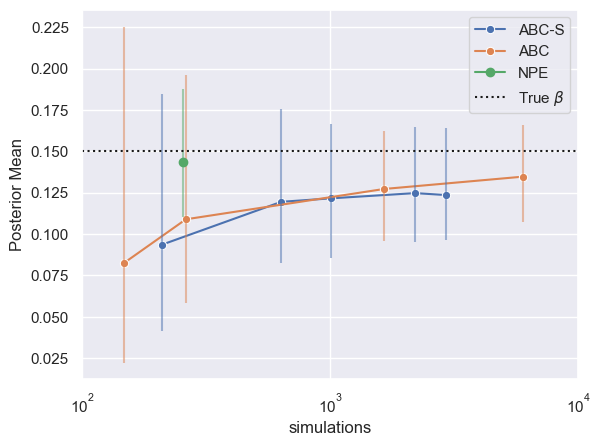

In [152]:
ax = sns.lineplot(df_abc[:5], x="simulations", y="Posterior Mean", marker="o", label="ABC-S")
sns.lineplot(df_abc[5:], x="simulations", y="Posterior Mean", marker="o", label="ABC")
plt.vlines(df_abc[:5]["simulations"], ymin = df_abc[:5][".05"], ymax=df_abc[:5][".95"], alpha=0.5)
plt.vlines(df_abc[5:]["simulations"], ymin = df_abc[5:][".05"], ymax=df_abc[5:][".95"], alpha=0.5, color=colors[1])
plt.plot(256, np.exp(-1.939), marker="o", label="NPE")
# plt.plot(256, np.exp(norm(-1.939, 0.161).ppf(.05)), marker="x", color=colors[2])
# plt.plot(256, np.exp(norm(-1.939, 0.161).ppf(.95)), marker="x", color=colors[2])
plt.vlines(256, ymin=np.exp(norm(-1.939, 0.161).ppf(.05)), ymax=np.exp(norm(-1.939, 0.161).ppf(.95)), color=colors[2], alpha=0.5)
ax.axhline(y = 0.15, color="k", label=r"True $\beta$", linestyle=":")
plt.legend()
plt.xscale("log")
ax.set_xticks([100, 1000, 10000])
plt.show()

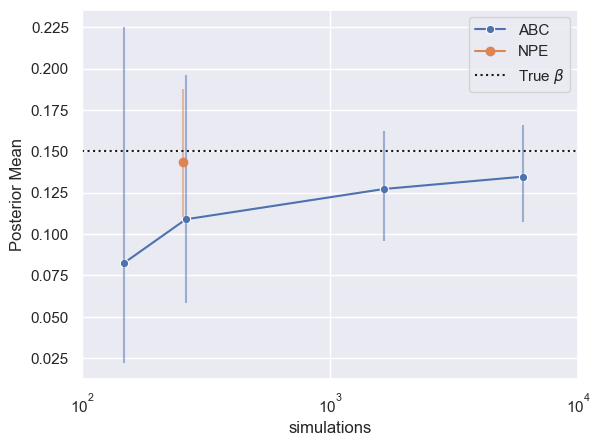

In [155]:
# ax = sns.lineplot(df_abc[:5], x="simulations", y="Posterior Mean", marker="o", label="ABC-S")
ax = sns.lineplot(df_abc[5:], x="simulations", y="Posterior Mean", marker="o", label="ABC")
# plt.vlines(df_abc[:5]["simulations"], ymin = df_abc[:5][".05"], ymax=df_abc[:5][".95"], alpha=0.5)
plt.vlines(df_abc[5:]["simulations"], ymin = df_abc[5:][".05"], ymax=df_abc[5:][".95"], alpha=0.5)
plt.plot(256, np.exp(-1.939), marker="o", label="NPE")
# plt.plot(256, np.exp(norm(-1.939, 0.161).ppf(.05)), marker="x", color=colors[2])
# plt.plot(256, np.exp(norm(-1.939, 0.161).ppf(.95)), marker="x", color=colors[2])
plt.vlines(256, ymin=np.exp(norm(-1.939, 0.161).ppf(.05)), ymax=np.exp(norm(-1.939, 0.161).ppf(.95)), color=colors[1], alpha=0.5)
ax.axhline(y = 0.15, color="k", label=r"True $\beta$", linestyle=":")
plt.legend()
plt.xscale("log")
ax.set_xticks([100, 1000, 10000])
plt.show()

In [131]:
plt.rcParams['axes.prop_cycle'].by_key()["color"]

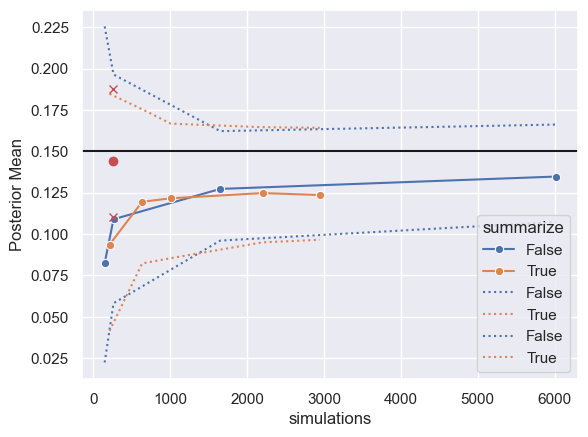

In [112]:
ax = sns.lineplot(df_abc, x="simulations", y="Posterior Mean", hue="summarize", marker="o")
sns.lineplot(df_abc, x="simulations", y=".95", hue="summarize", linestyle=":")
sns.lineplot(df_abc, x="simulations", y=".05", hue="summarize", linestyle=":")
ax.axhline(y = 0.15, color="k")
ax.plot(256, np.exp(-1.939), "ro")
ax.plot(256, np.exp(norm(-1.939, 0.161).ppf(.05)), "rx")
ax.plot(256, np.exp(norm(-1.939, 0.161).ppf(.95)), "rx")
plt.show()

In [ ]:
ax = sns.lineplot(df_abc, x="simulations", y="Posterior Mean", hue="summarize")
ax.axhline(y = 0.15, color="k")
ax.plot(256, np.exp(-1.939), "ro")
plt.show()

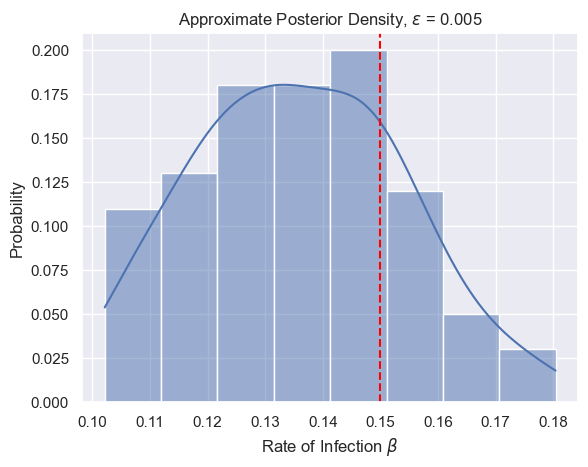

In [53]:
ax = sns.histplot(np.exp(abc_posterior[8]), stat="probability", kde=True)
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(rf"Approximate Posterior Density, $\epsilon$ = {0.005}")
plt.axvline(beta_true, color="red", linestyle="--")
# x.get_legend().remove()
plt.show()

In [48]:
np.log(0.15)

-1.8971199848858813

In [40]:
np.exp(-1.939)

0.14384772560341216

#### Summary Statistic

In [74]:
# summarize = True
# si_model = SIModel(alpha, gamma, beta_true, 
#                     n_zones, prior_mu, prior_sigma, 
#                    N, T, summarize=summarize)
# prior_sampler = lambda: si_model.sample_logbeta(1)
# simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
# x_o = si_model.get_observed_data(29)
# if not summarize:
#     x_o = x_o.transpose(0, 1)
# S = 100
# epsilon = 0.001
# posterior_sample, errors = abc_rejection_sampler(
#     S, epsilon, prior_sampler, simulator, x_o, max_attempts=20000,
#     summarize=summarize
#     )
# ax = sns.histplot(np.exp(posterior_sample), stat="probability", kde=True)
# ax.set_xlabel(r"Rate of Infection $\beta$")
# ax.set_title(rf"Approximate Posterior Density, $\epsilon$ = {epsilon}")
# plt.axvline(beta_true, color="red", linestyle="--")
# ax.get_legend().remove()
# plt.show()

### NPE

Hyperparameters: 1024 observations, network dimension 8, 400 training epochs

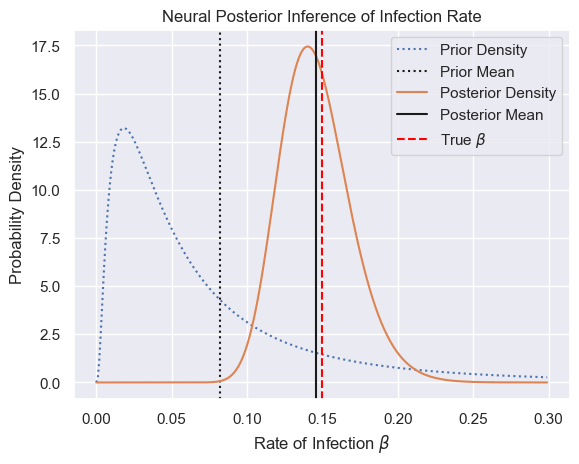

In [11]:
mu = - 1.939
sigma = 0.161
np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Posterior Density")
plt.axvline(posterior_mean, color="k", label="Posterior Mean")
plt.axvline(beta_true, color="red", linestyle="--", label=r"True $\beta$")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_ylabel("Probability Density")
ax.set_title(f"Neural Posterior Inference of Infection Rate")
plt.legend()
plt.show()

In [73]:
# np.random.seed(10)
# x = np.arange(-6., 0, 0.01)
# ax = sns.lineplot(x=x, y=norm.pdf(x, mu, sigma), label="Posterior Density")
# ax1 = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma), 
#                    label="Prior Density", linestyle=":")
# ax.set_xlabel(r"$\log(\beta)$")
# ax.set_title(f"Neural Posterior Inference of Infection Rate, Log-scale")
# posterior_mean = np.exp(mu + sigma**2/2)
# plt.axvline(prior_mu, color="k", linestyle=":")
# plt.axvline(mu, color="k")
# plt.axvline(np.log(beta_true), color="red", linestyle="--", label="True")
# plt.show()

## Posterior Predictive Checks

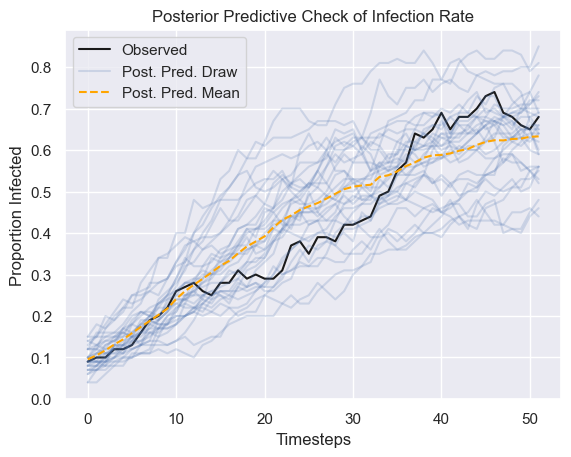

In [69]:
mu = - 1.939
sigma = 0.161
neural_posterior = norm(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))


for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate")
plt.ylabel("Proportion Infected")
plt.xlabel("Timesteps")
plt.show()

### ABC PPC

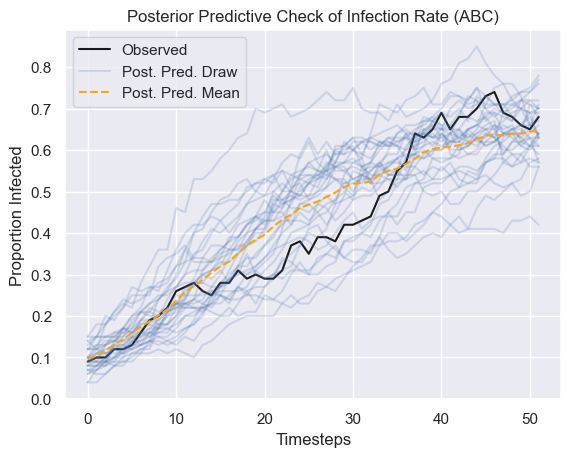

In [67]:
posterior_predictive_abc = np.empty((K, T))
for i in range(30):
    beta = np.exp(abc_posterior[8][i])
    si_model = SIModel(alpha, gamma, beta, 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive_abc[i] =  np.array(x_rep)[0]
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Proportion Infected")
plt.xlabel("Timesteps")
plt.show()

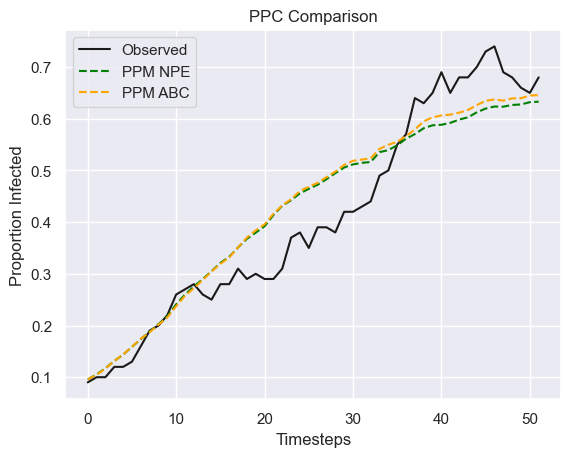

In [70]:
plt.plot(I_o, label="Observed", color="k")
plt.plot(pp_mean, label="PPM NPE", linestyle="--",
         color="green")
plt.plot(pp_mean_abc, label="PPM ABC", linestyle="--",
         color="orange")
plt.legend()
plt.title("PPC Comparison")
plt.ylabel("Proportion Infected")
plt.xlabel("Timesteps")
plt.show()

## Summary Stat NPE

In [71]:
# mu = - 2.1
# sigma = 0.198
# np.random.seed(10)
# x = np.arange(0., 0.3, 0.001)
# ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Posterior Density")
# ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
#                    label="Prior Density", linestyle=":")
# ax.set_xlabel(r"Rate of Infection $\beta$")
# ax.set_title(f"Neural Posterior Inference with Summary Statistic")
# posterior_mean = np.exp(mu + sigma**2/2)
# plt.axvline(prior_mean, color="k", linestyle=":")
# plt.axvline(posterior_mean, color="k")
# plt.axvline(beta_true, color="red", linestyle="--", label="True")
# plt.show()

In [72]:
# neural_posterior = norm(mu, sigma)
# K = 30
# npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
# posterior_predictive = np.empty((K, T))


# for i in range(K):
#     si_model = SIModel(alpha, gamma, npe_sample[i], 
#                    n_zones, prior_mu, prior_sigma,
#                    N, T, summarize=False)
#     x_rep = si_model.get_observed_data(i)
#     posterior_predictive[i] =  np.array(x_rep)[0]
# pp_mean = posterior_predictive.mean(0)

# labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
# I_o = np.array(x_o_raw)[0]
# S_o  = 1 - I_o
# plt.plot(I_o, label="Observed", color="k")
# plt.plot(posterior_predictive.T, 
#          label=labels, color="b",
#          alpha=0.2)
# plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
#          color="orange")
# plt.legend()
# plt.title("Posterior Predictive Check with Summary Statistic")
# plt.show()